## Exercises
1. The end result of this exercise should be a Jupyter notebook named model.
2. Using saas.csv or log data from API usage or store_item_sales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import timedelta, datetime
from time import strftime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

import acquire, prepare

In [41]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [19]:
# Load saas data

df = pd.read_csv('saas.csv')

# Print the shape
print(df.shape)

df.head()

(790458, 5)


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [22]:
# Any missing values?
df.isna().sum().sum()

0

**Takeaways**
1. change the column names to lower case. 
2. set the date column to index
3. no missing values

In [23]:
# Create a function to process the data

def prep_data(df):
    df.columns = [col.lower() for col in df.columns] # Convert column names to lower case
    df.month_invoiced = pd.to_datetime(df.month_invoiced)
    df = df.set_index('month_invoiced').sort_index()
    return df

In [24]:
# Preprocess the df

df = prep_data(df)
df.shape

(790458, 4)

In [38]:
# Quick check the processed data
df.tail()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0
2017-12-31,1029398,5790456,0.0,0.0
2017-12-31,1029399,5790457,0.0,0.0


In [31]:
# Check the index
print(df.index.dtype) # in the datetime format

datetime64[ns]


In [32]:
# Summarize the df
print('Date Range:', df.index.min(), 'to', df.index.max()) # From Jan 2014 to 2017 (whole year)

Date Range: 2014-01-31 00:00:00 to 2017-12-31 00:00:00


In [33]:
# How many unique customer_ids
df.customer_id.value_counts().size # 29400 unique customer_ids

29400

In [34]:
# How many unique invoice_ids?
df.invoice_id.value_counts().size # 790458 unique invoice_ids so invoice_id is unique

790458

In [35]:
# How many unique subscription_type?
df.subscription_type.value_counts() # 5 unique subscription types so subscription_type is the categorical

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

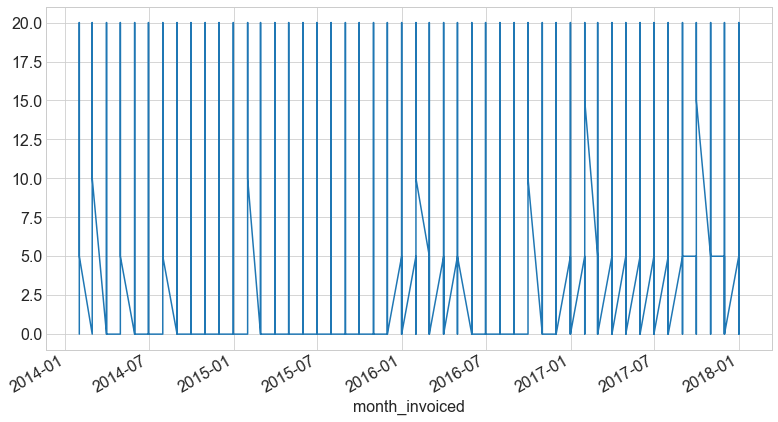

In [47]:
# Plot the amout over time
df.amount.plot()

### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [48]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

validate_end_index

632366

In [49]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

### Verify Splits

In [50]:
# Does the length of each df equate to the length of the original df?
print(len(train) + len(validate) + len(test) == len(df))

True


In [51]:
# Does the first row of original df equate to the first row of train?
print(df.head(1) == train.head(1))

                customer_id  invoice_id  subscription_type  amount
month_invoiced                                                    
2014-01-31             True        True               True    True


In [52]:
# Is the last row of train the day before the first row of validate? 
pd.concat([train.tail(1), validate.head(1)])

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2015-10-31,1019181,5395228,0.0,0.0
2015-10-31,1019182,5395229,0.0,0.0


In [53]:
# And the same for validate to test?
pd.concat([validate.tail(1), test.head(1)])

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2017-01-31,1026538,5632365,0.0,0.0
2017-01-31,1026539,5632366,0.0,0.0


In [54]:
# Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), df.tail(1)])

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2017-12-31,1029399,5790457,0.0,0.0
2017-12-31,1029399,5790457,0.0,0.0


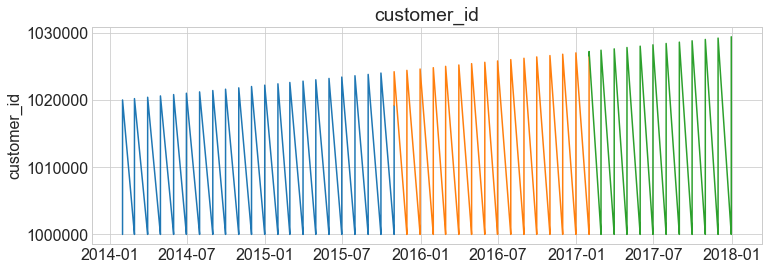

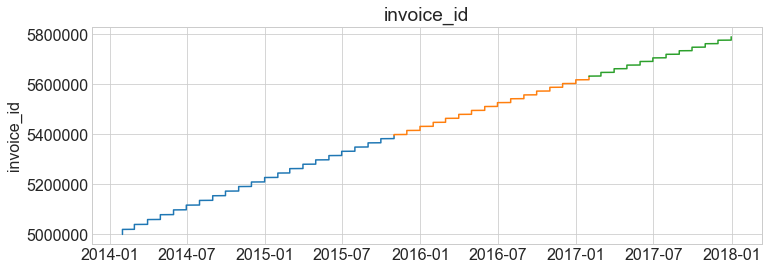

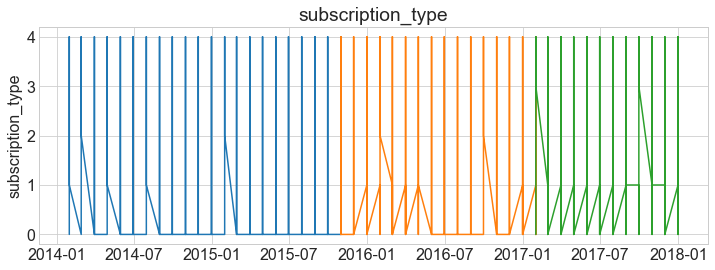

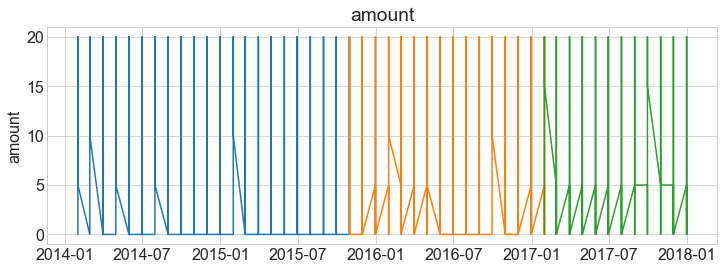

In [55]:
# Let's plot our data first, viewing where the data is split into train and test.

for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()